In [6]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import json
from matplotlib import pyplot as plt
import numpy as np
from baselines import ZeroBaselineFactory
from models import load_distilbert

from numpy.random import randn
from evaluators import ProportionalityEvaluator
import nevergrad as ng
from concurrent import futures


In [12]:
def square(x):
    return sum((x - 0.5) ** 2)

# optimization on x as an array of shape (2,)
optimizer = ng.optimizers.NGOpt(parametrization=2, budget=100, num_workers=2)

with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
    recommendation = optimizer.minimize(square, executor=executor, batch_mode=False)
print(recommendation.value)

[0.5 0.5]


In [13]:
print(sorted(ng.optimizers.registry.keys()))


['ASCMADEthird', 'AdaptiveDiscreteOnePlusOne', 'AlmostRotationInvariantDE', 'AnisotropicAdaptiveDiscreteOnePlusOne', 'AvgMetaRecenteringNoHull', 'BO', 'BOSplit', 'BayesOptimBO', 'CM', 'CMA', 'CMandAS2', 'CMandAS3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'ChainCMAPowell', 'ChainDiagonalCMAPowell', 'ChainMetaModelPowell', 'ChainMetaModelSQP', 'ChainNaiveTBPSACMAPowell', 'ChainNaiveTBPSAPowell', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteBSOOnePlusOne', 'DiscreteDoerrOnePlusOne', 'DiscreteLenglerOnePlusOne', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'FCMA', 'GeneticDE', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'HullAvgMetaRecentering', 'HullAvgMetaTuneRecentering', 'LHSSearch', 'LargeHaltonSearch', 'LhsDE', 'MetaModel', 'MetaModelOnePlusOne', 'MetaRecentering', 'MetaTuneRecentering', 'MixES', 'MultiCMA', 'MultiDiscrete', 'MultiScaleCMA', 'MutDE', 'NGO', 'NGOpt', 'NGOpt10', 'NG

In [74]:
model = load_distilbert(from_notebook=1)
with open("./../data/imdb-distilbert-first-1000.json", "r") as fp:
    dataset = json.load(fp)


In [75]:
for observation in dataset:
    cnt = 0
    idx = None
    for i,token in enumerate(observation['tokens']):
        if '.' in token:
        #    cnt += 1
        #if cnt == 2:
            idx = i
            print(i)
            observation['input_ids'] = observation['input_ids'][:idx]
            observation['attention_mask'] = observation['attention_mask'][:idx]
            observation['tokens'] = observation['tokens'][:idx]
            break

15
15
32
85
29
37
18
17
14
18
8
24
21
10
62
8
48
21
25
177
5
13
26
73
8
38
12
8
31
20
24
40
31
25
40
48
75
30
41
39
17
10
13
24
11
16
74
17
29
18
11
11
26
43
137
3
37
18
56
29
15
10
9
13
21
40
8
40
26
3
12
30
4
13
73
57
45
16
22
22
32
27
10
9
17
35
33
73
8
23
35
17
48
94
56
18
11
22
24
61
31
26
17
37
20
82
14
13
18
12
14
29
14
16
13
14
44
38
24
20
16
51
13
14
9
28
12
4
16
32
25
10
39
39
48
23
13
35
29
33
38
24
14
6
14
12
4
21
37
8
22
19
34
11
27
30
15
21
32
17
73
22
26
41
25
7
13
33
24
25
39
44
13
25
60
14
32
16
17
23
41
38
26
35
20
41
32
54
18
14
20
13
12
32
49
67
16
7
39
15
17
13
22
16
5
34
38
11
16
16
16
30
30
26
26
28
35
51
12
34
24
3
7
22
20
22
11
6
46
13
11
65
21
26
31
25
19
25
27
50
107
72
34
94
15
11
28
19
20
18
55
11
13
44
39
22
2
27
27
18
20
33
48
26
7
17
15
36
57
17
5
10
26
36
21
38
11
27
34
23
14
8
17
27
42
8
12
10
19
13
26
13
33
28
17
11
12
23
27
23
17
11
17
45
24
36
7
6
9
30
41
17
33
37
3
34
14
15
27
19
55
32
20
98
17
18
21
9
23
15
15
15
19
26
7
31
47
11
11
41
23
28
24
27

In [76]:
observation = np.asarray(dataset[0]["input_ids"][:512])
evaluator = ProportionalityEvaluator(model=model, baseline_factory=ZeroBaselineFactory)
objective = lambda candidate: evaluator.compute_tpn(observation=observation, attribution_values=candidate)

res = objective(np.random.random(observation.shape))  # objective should be called on attributions
print(res)

0.10311938906179224


In [77]:
evaluator = ProportionalityEvaluator(model=model, baseline_factory=ZeroBaselineFactory)
results = []
for observation in dataset[:100]:
    observation = np.asarray(observation["input_ids"])


    def objective(candidate):
        res = evaluator.compute_tpn(observation=observation, attribution_values=candidate)
        if res is None:
            return 10 # float("inf")
        return res


    param = ng.p.Array(shape=observation.shape)
    param.set_bounds(lower=0)
    param.set_mutation(sigma=1)

    optimizer = ng.optimizers.NGOpt(parametrization=param, budget=300, num_workers=4)
    with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
        recommendation = optimizer.minimize(objective,executor=executor, batch_mode=False)
    print(objective(recommendation.value))
    results.append(recommendation)
    # print(recommendation.value)
    #plt.scatter(y=recommendation.value, x=list(range(len(recommendation.value))))
    # plt.hist(recommendation.value, bins=50)



0.001974343638382451
0.0024430478841208025
0.014036239161498817
0.003022513163356792
0.003654173749412166
0.012071879501730708
0.09416731972689833
0.0023068389849564223
0.005165421627510061
0.07158235919729529
0.031796299687091405
0.007457936534688701
0.07190112540092272
0.010260848722817647
0.016128862749529974
0.005294861227379262
0.020948823825373334
0.002742861687828678
0.08257106856150813
0.0224035170345335
0.00849448320055944
0.004771402331275412
0.005504342238274386
0.0009217600428230165
0.009119708503935951
0.00897573809340036
0.0014018610332348018
0.012398586766411127
0.009783031933103654
0.0010806921522324019
0.0045268539401953365
0.007412603121002974
0.011557294417105827
0.004443268467222495
0.0349500600065404
0.023355705558347428
0.007379466015270911
0.01092864094479722


KeyboardInterrupt: 

/tmp/ipykernel_7522/1159104269.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


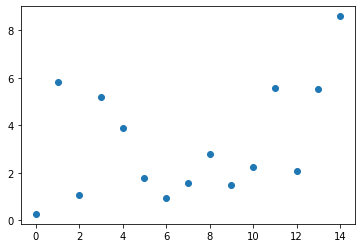

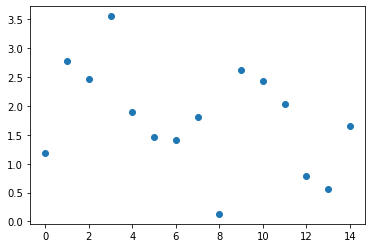

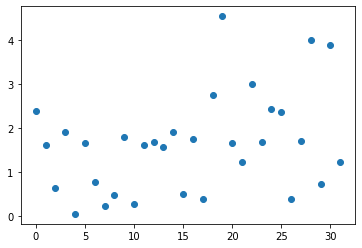

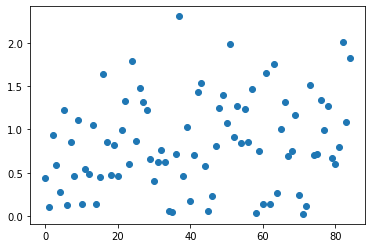

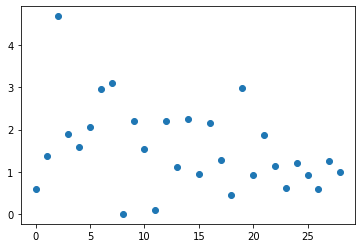

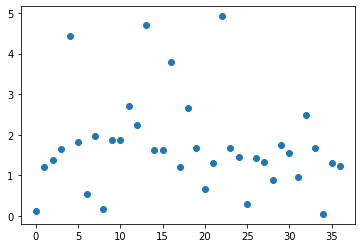

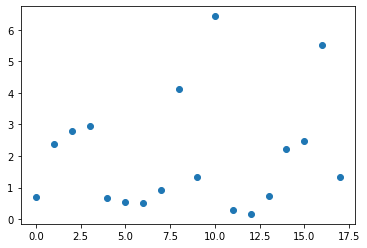

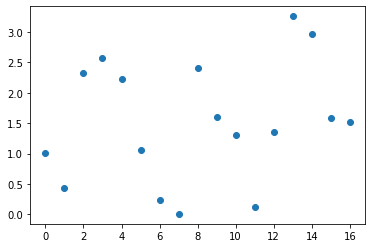

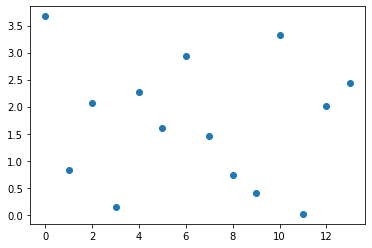

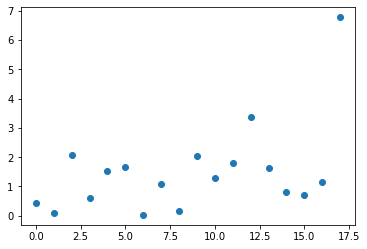

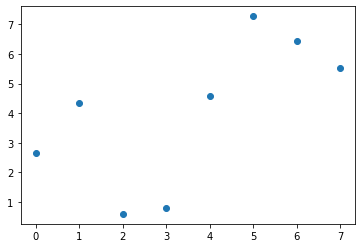

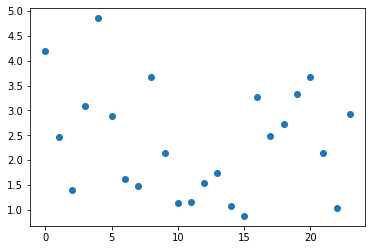

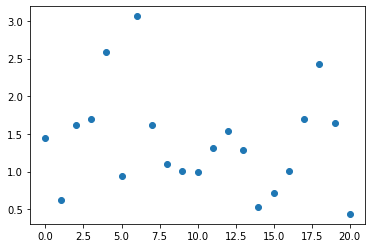

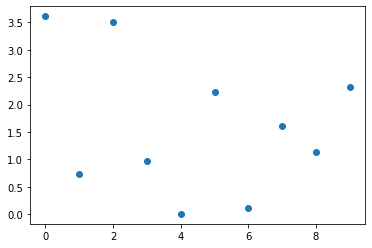

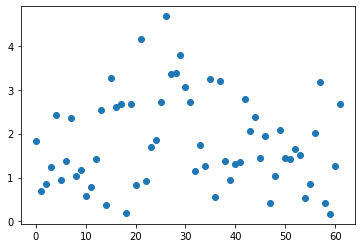

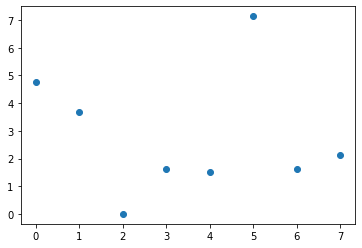

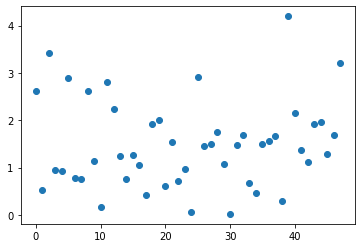

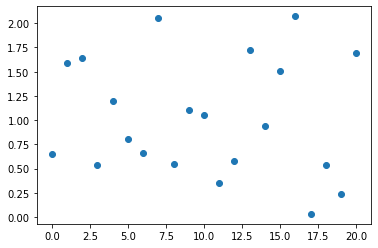

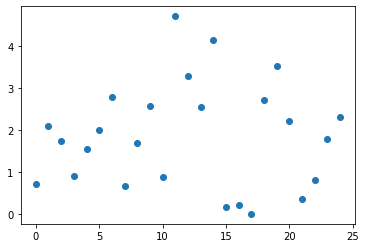

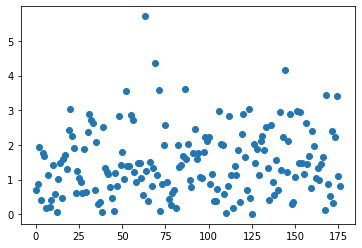

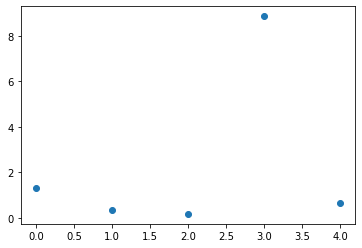

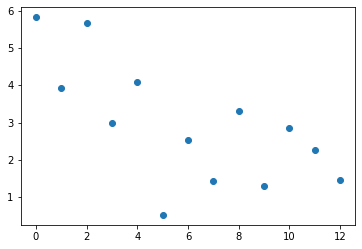

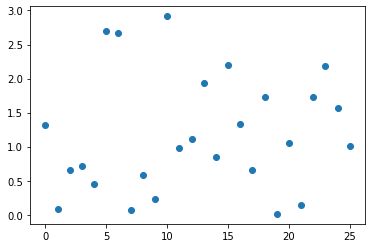

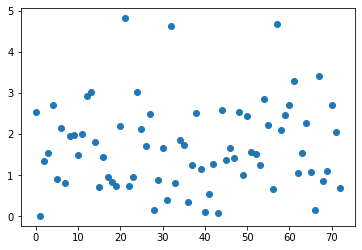

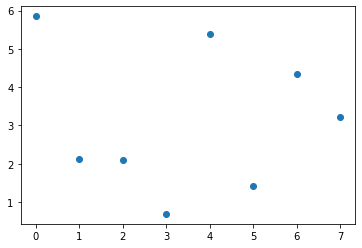

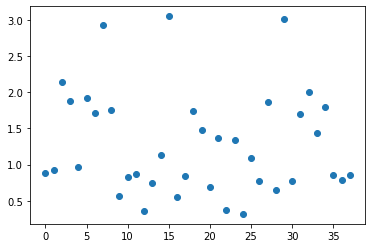

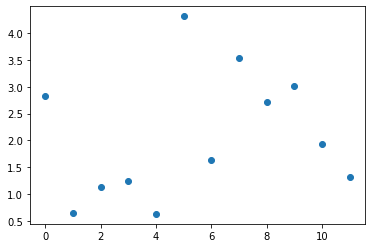

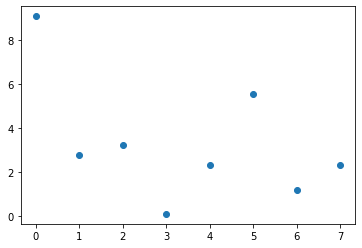

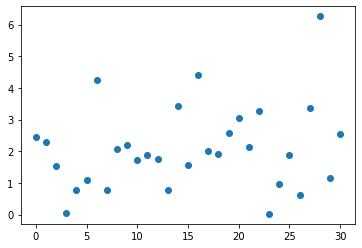

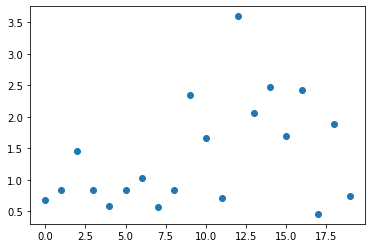

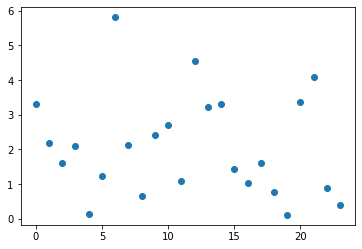

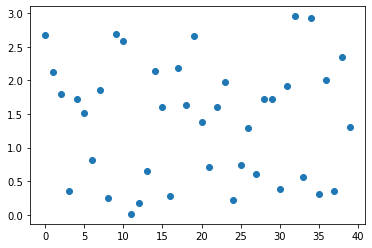

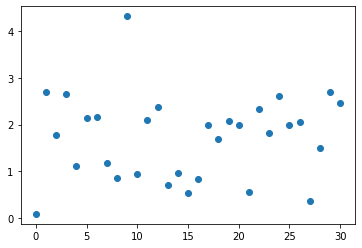

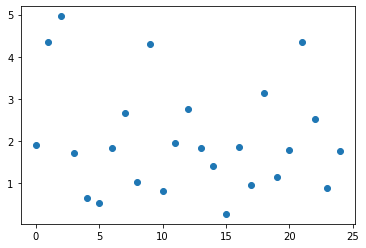

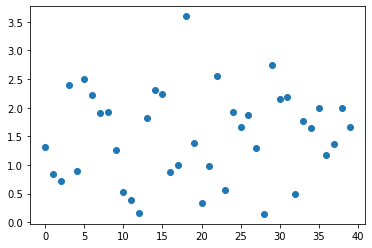

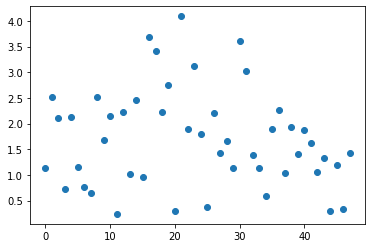

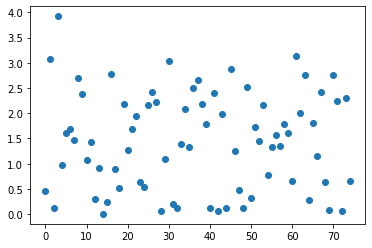

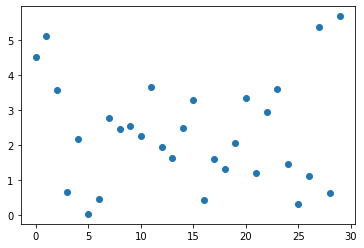

In [78]:
import time
for i, recommendation in enumerate(results):
    fig, ax = plt.subplots()
    ax.scatter(y=recommendation.value, x=list(range(len(recommendation.value))))
    fig.savefig(f"./scatter{i}-{time.strftime('%m%d%Y%H%M%S')}.png")